# Fourier Neural Operator for 2-D Darcy Flow
<!-- @script made by: Kai Chang -->

This script takes a deep look into the dataset for 2-dimensional Darcy Flow used in [[Li et al., 2020]](https://arxiv.org/abs/2010.08895) and walks through the implementation of 1-D fourier neural operator. 

## Problem Statement
We intend to solve the equation

\begin{align}
-\nabla\cdot(a(x)\nabla u(x)) &= f(x) \quad &x\in (0,1) \times (0,1)\\
u(x) &= 0 &x\in \partial \left\{(0,1) \times (0,1)\right\}
\end{align}

with a Dirichlet boundary condition where $a \in L^{\infty}\left((0,1);\mathbb{R}\right).$

## Goal:
### To learn a map from the space of diffusion coefficient functions to the solution; i.e. $a \mapsto u$.

## Dataset

Let's first take a look at the dataset to get us better understand some of the technicalities in the implementation. It contains the solution to 2-D Darcy Flow with different diffusion coefficient functions. The dataset is generated by classical PDE solvers. The raw data is a dictionary. The key `'coeff'` corresponds to the input while `'sol'` labels the ground truth. 

In this case, the domain of the map we want to approximate is the space of diffusion coefficient functions; the codomain is the space of the solutions. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities import *
from Adam import Adam
import random
from plot_lib import plot_loss, plt_set_default
import os

plt_set_default()

In [2]:
# file_path = "./data/Burgers/burgers_v100_t100_r1024_N2048.mat"
train_path = "../data/Darcy_421/piececonst_r421_N1024_smooth1.mat"
test_path = "../data/Darcy_421/piececonst_r421_N1024_smooth2.mat"
dataloader_train = MatReader(train_path)
dataloader_test = MatReader(test_path)
print('train keys: ', dataloader_train.data.keys())
print('test keys: ', dataloader_test.data.keys())

train keys:  dict_keys(['__header__', '__version__', '__globals__', 'Kcoeff', 'Kcoeff_x', 'Kcoeff_y', 'coeff', 'sol'])
test keys:  dict_keys(['__header__', '__version__', '__globals__', 'Kcoeff', 'Kcoeff_x', 'Kcoeff_y', 'coeff', 'sol'])


In [3]:
a_train_raw = dataloader_train.read_field('coeff')
print('a_train_raw.size(): ', a_train_raw.size())
u_train_raw = dataloader_train.read_field('sol')
print('u_train_raw.size(): ', u_train_raw.size())
a_test_raw = dataloader_test.read_field('coeff')
print('a_test_raw.size(): ', a_test_raw.size())
u_test_raw = dataloader_test.read_field('sol')
print('u_test_raw.size(): ', u_test_raw.size())

# train_sub = 5
# test_sub = 1
# train_res = a_train_raw.size(1)//train_sub + 1
# test_res = a_test_raw.size(1)//test_sub if a_test_raw.size(1)%test_sub == 0 else a_test_raw.size(1)//test_sub + 1
# print('train_res: ', train_res)
# print('test_res: ', test_res)
# n_train = 1000
# n_test = 100

# a_train = a_train_raw[:n_train,::train_sub, ::train_sub]
# print('a_train.size(): ', a_train.size())
# a_test = a_test_raw[:n_test,::test_sub, ::test_sub]
# print('a_test.size(): ', a_test.size())
# u_train = u_train_raw[:n_train,::train_sub, ::train_sub]
# print('u_train.size(): ', u_train.size())
# u_test = u_test_raw[:n_test,::test_sub, ::test_sub]
# print('u_test.size(): ', u_test.size())

a_train_raw.size():  torch.Size([1024, 421, 421])
u_train_raw.size():  torch.Size([1024, 421, 421])
a_test_raw.size():  torch.Size([1024, 421, 421])
u_test_raw.size():  torch.Size([1024, 421, 421])


We see the size of the data is 1024 x 421 x 421. This means that we have 1024 training samples and the discretization size is 421 x 421. We, however, are not provided the discretized space in the dataset, which apparently is essential for our learning task. Therefore, in the implementation of the architecture, we need to recover that on our own. 

In preparing the dataset, note that we've sampled from the raw data to make our training data coarser. This is to test the claim in the paper that FNO can achieve high accuracy on fine mesh even if it is trained on coarser mesh. 

## FNO Implementation

Now we take a look at the implementation of the method.

To begin with, we need the basic building block in a FNO; that is, a fourier layer.

In [4]:
class FourierLayer2d(nn.Module):
    """
    2D Fourier layer. 
    
    ->input => FFT => multiplied by a (kernel) matrix => inverse FFT => add Wv_t => output
    """
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = Parameter(self.scale * torch.rand(in_channels, 
                                                          out_channels, 
                                                          self.modes1, 
                                                          self.modes2, 
                                                          dtype=torch.cfloat))
        
        self.weights2 = Parameter(self.scale * torch.rand(in_channels, 
                                                          out_channels, 
                                                          self.modes1, 
                                                          self.modes2, 
                                                          dtype=torch.cfloat))
        
        self.w = nn.Conv2d(in_channels, out_channels, 1)

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x, y), (in_channel, out_channel, x, y) -> (batch, out_channel, x, y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        # the reason of out_ft.size(3) = resolution//2 + 1 is because here we are using rfft
        # which takes the fact that the DFT of real modes is Hermitian
        # Therefore, only half of the entries needs to be stored.
        # This is also the reason that we are only doing multiplication half of the usual times
        out_ft = torch.zeros(batchsize, 
                             self.out_channels,  
                             x.size(-2),
                             x.size(-1)//2 + 1,
                             dtype=torch.cfloat, 
                             device=x.device)
        
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x1 = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        x2 = self.w(x)
        return x1 + x2

We are now ready to implement the whole network.

In [13]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super().__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = FourierLayer2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = FourierLayer2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = FourierLayer2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = FourierLayer2d(self.width, self.width, self.modes1, self.modes2)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        """
        x.size() = (batch, resolution_x, resolution_y, 1)
        """
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        # now shape becomes (batch, resolution_x, resolution_y, 3)
        # channel: [a(x,y), x, y]
        
        x = self.fc0(x)
        # now shape becomes (batch, resolution_x, resolution_y, width)
        
        x = x.permute(0, 3, 1, 2)
        # now shape becomes (batch, width, resolution_x, resolution_y)
        
#         x = F.pad(x, [0,self.padding, 0,self.padding]) # dataset adopts Dirichlet BC

        h1 = self.conv0(x)
        x = F.gelu(h1) + x

        h2 = self.conv1(x)
        x = F.gelu(h2) + x

        h3 = self.conv2(x)
        x = F.gelu(h3) + x

        h4 = self.conv3(x)
        x = h4 + x

#         x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        # now shape becomes (batch, resolution_x, resolution_y, width)
        
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x # x.shape = (batch, resolution_x, resolution_y, 1)
    
    def get_grid(self, shape, device):
        """
        shape: (batch, resolution_x, resolution_y, 1)
        """
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        # shape (batch, resolution_x, resolution_y, 1); encode x-coordinate
        
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        # shape (batch, resolution_x, resolution_y, 1); encode y-coordinate
        
        return torch.cat((gridx, gridy), dim=-1).to(device) 
               # shape (batch, resolution_x, resolution_y, 2)
        

# Training and Testing

### Input: diffusion coefficient function $a(x)$ evaluated at some discretized grids of the domain and the location of the grid
### Output: solution function $u(x)$ evaluated at some discretized grids (might be different from that of the input) of the domain

In [14]:
train_sub = 5
test_sub = 5
train_res = a_train_raw.size(1)//train_sub + 1
test_res = a_test_raw.size(1)//test_sub if a_test_raw.size(1)%test_sub == 0 else a_test_raw.size(1)//test_sub + 1
n_train = 1000
n_test = 200

a_train = a_train_raw[:n_train,::train_sub, ::train_sub]
a_test = a_test_raw[:n_test,::test_sub, ::test_sub]
u_train = u_train_raw[:n_train,::train_sub, ::train_sub]
u_test = u_test_raw[:n_test,::test_sub, ::test_sub]

a_normalizer = UnitGaussianNormalizer(a_train)
a_train = a_normalizer.encode(a_train)
a_test = a_normalizer.encode(a_test)

u_normalizer = UnitGaussianNormalizer(u_train)
u_train = u_normalizer.encode(u_train)

a_train = a_train.reshape(n_train,train_res,train_res,1)
a_test = a_test.reshape(n_test,test_res,test_res,1)

2368001


<IPython.core.display.Javascript object>


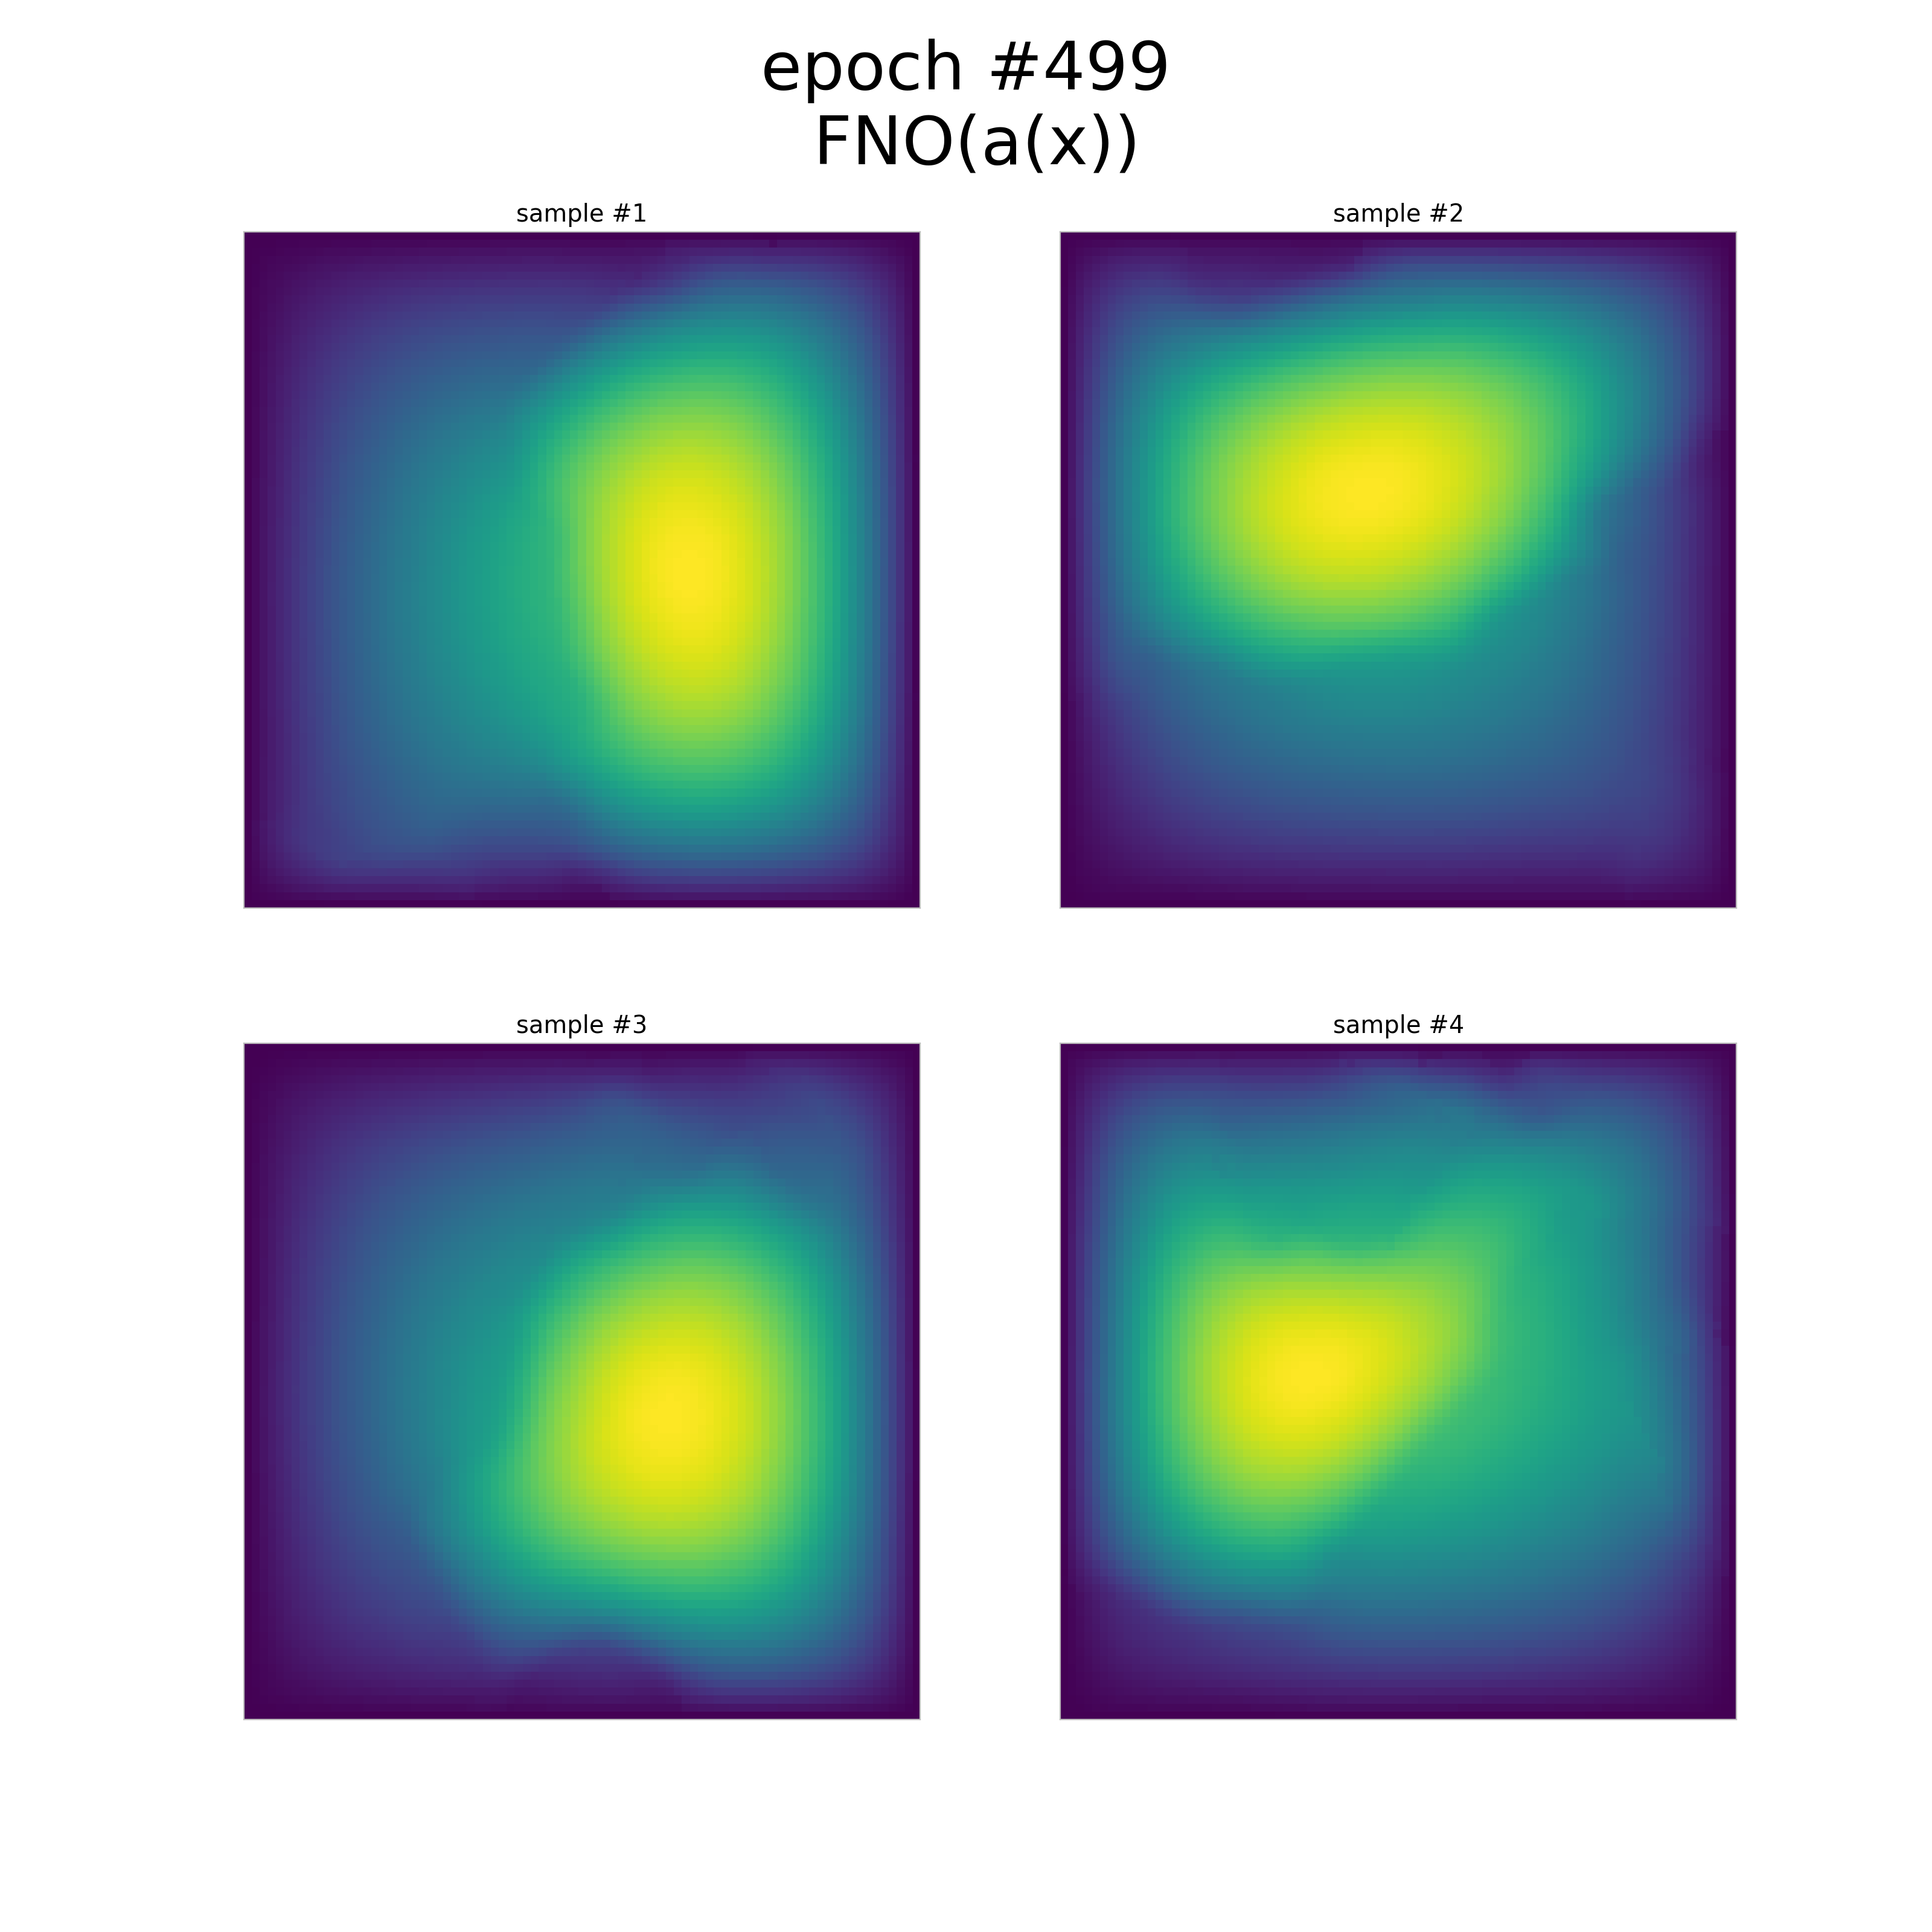

epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
0		1.20349 		0.13429 	 0.11482


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
25		1.06752 		0.02011 	 0.02243


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
50		1.12320 		0.01834 	 0.01870


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
75		1.00284 		0.01537 	 0.01831


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
100		1.38612 		0.01298 	 0.01644


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
125		1.20719 		0.01170 	 0.01369


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
150		1.07438 		0.01181 	 0.01434


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
175		0.98967 		0.01138 	 0.01317


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
200		1.02293 		0.00994 	 0.01197


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
225		1.09087 		0.00990 	 0.01203


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
250		1.01890 		0.00962 	 0.01155


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
275		1.36863 		0.00922 	 0.01125

In [17]:
%matplotlib notebook

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

###################################################
################## model configs ##################
###################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 20
learning_rate = 0.001
epochs = 500

# for scheduler's use 
# for every <step_size> epochs, the learning rate will be multiplied by <gamma>
step_size = 100
gamma = 0.5
modes = 12
width = 32

model = FNO2d(modes, modes, width).to(device)
print(count_params(model))

optimizer = Adam(model.parameters(), 
                 lr=learning_rate, 
                 weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=step_size,
                                            gamma=gamma)
myloss = LpLoss()#size_average=False) # default is relative L2 norm

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(a_train, u_train), 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(a_test, u_test), 
                                          batch_size=batch_size, 
                                          shuffle=False)
train_L2_Loss = []
test_L2_Loss = []

####################################################
################# plotting configs #################
####################################################

rows,cols = 2,2
num_plots = rows * cols
num_train_batch = n_train//batch_size
num_test_batch = n_test//batch_size
assert num_test_batch >= num_plots
sampled_batch_idx = random.sample(range(num_test_batch),num_plots)
sampled_plotting_idx = np.random.randint(batch_size, size = num_plots)


# if true, plot output solution; else plot absolute difference
plot_sol = True
if plot_sol:
    fig_sol = plt.figure(figsize = (16,16))
else:  
    fig_diff = plt.figure(figsize = (16,16))
plot_pos = 1

# xlabel = 'training resolution: ' + str(train_res) + '\n' + \
#          'testing resolution: ' + str(test_res)

# config for saving figures
saveFigSol = False
saveFigDiff = False

fig_folder = 'ep' + str(epochs) + \
             '-lr' + "".join(str(learning_rate).split('.')) + \
             '-decay' + "".join(str(gamma).split('.')) + \
             '-trainRes' + str(train_res) + \
             '-testRes' + str(test_res)

fig_dir = '../figs/darcy/' + fig_folder
if saveFigDiff or saveFigSol:
    if not os.path.isdir(fig_dir):
        os.makedirs(fig_dir)

for ep in range(epochs):
    if plot_sol:
        fig_sol.clear()
        fig_sol.suptitle('epoch #' + str(ep) + '\n FNO(a(x))',fontsize = 40)
    else:
        fig_diff.clear()
        fig_diff.suptitle('epoch #' + str(ep) + '\n |FNO(a(x))-Truth|',fontsize = 40)
    
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for batch, (a, u) in enumerate(train_loader):
        a, u = a.to(device), u.to(device)
        # a.shape = (batch, train_res, train_res, 1)
        # u.shape = (batch, train_res, train_res)
        

        optimizer.zero_grad()
        out = model(a).reshape(batch_size, train_res, train_res)
        # out.shape = (batch, train_res, train_res, 1)
        
        out = u_normalizer.decode(out)
        u = u_normalizer.decode(u)

        loss = myloss(out.view(batch_size,-1), u.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for batch, (a, u) in enumerate(test_loader):
            a, u = a.to(device), u.to(device)
            # a.shape = (batch, train_res, train_res, 1)
            # u.shape = (batch, train_res, train_res)

            out = model(a).reshape(batch_size, test_res, test_res)
            out = u_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), u.view(batch_size,-1)).item()
            
            ### plot sampled testing function ###
            if plot_sol:
                if batch in sampled_batch_idx:
                    idx = sampled_plotting_idx[plot_pos-1]

                    # plot outputs of several sampled inputs
                    ax = fig_sol.add_subplot(rows,cols,plot_pos)
                    ax.clear()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)

                    out_sample = out[idx,:,:].reshape((test_res,test_res,1))
                    out_sample = out_sample.detach().cpu().numpy()
                    ax.set_title(f"sample #{plot_pos}")
                    ax.imshow(out_sample)
#                     plt.colorbar(im)
                    
                    plot_pos += 1
                    
            else:
                if batch in sampled_batch_idx:
                    idx = sampled_plotting_idx[plot_pos-1]
                    
                    # plot absolute difference between the outputs and ground truth
                    ax2 = fig_diff.add_subplot(rows,cols,plot_pos)
                    ax2.clear()
#                     ax2.get_xaxis().set_visible(False)
#                     ax2.get_yaxis().set_visible(False)
                    truth_sample = u[idx,:,:].reshape((test_res,test_res,1))
                    out_sample = out[idx,:,:].reshape((test_res,test_res,1))
                    
                    diff_sample = torch.abs(truth_sample.detach() - out_sample.detach()) \
                                  .detach().cpu().numpy()
                    im2 = ax2.imshow(diff_sample)
                    ax2.set_title(f"sample #{plot_pos}")

                    plot_pos += 1
                    plt.colorbar(im2)
        
        if plot_sol:
            fig_sol.canvas.draw()
        else:
            fig_diff.canvas.draw()
        plot_pos = 1
        
        if plot_sol and saveFigSol:
            if fig_dir[-1] != '/':
                fig_dir = fig_dir + '/'
            fig_sol_dir = fig_dir + 'sol/'
            if not os.path.isdir(fig_sol_dir):
                os.makedirs(fig_sol_dir)
            fig_sol_name = fig_sol_dir + 'epoch-' + str(ep) + '.png'
            fig_sol.savefig(fig_sol_name)
        
        if (not plot_sol) and saveFigDiff:
            if fig_dir[-1] != '/':
                fig_dir = fig_dir + '/'
            fig_diff_dir = fig_dir + 'diff/'
            if not os.path.isdir(fig_diff_dir):
                os.makedirs(fig_diff_dir)
            fig_diff_name = fig_diff_dir + 'epoch-' + str(ep) + '.png'
            fig_diff.savefig(fig_diff_name)
        
    train_l2 /= num_train_batch
    train_L2_Loss.append(train_l2)
    
    test_l2 /= num_test_batch
    test_L2_Loss.append(test_l2)

    t2 = default_timer()
    if ep%25 == 0 or ep == (epochs-1):
        print('epoch \t\t t2-t1 \t\t train-L2-Error \t test-L2-Error')
        print('{0:d}\t\t{1:.5f} \t\t{2:.5f} \t {3:.5f}' \
              .format(ep, t2-t1, train_l2, test_l2))
        print('\n')

<IPython.core.display.Javascript object>


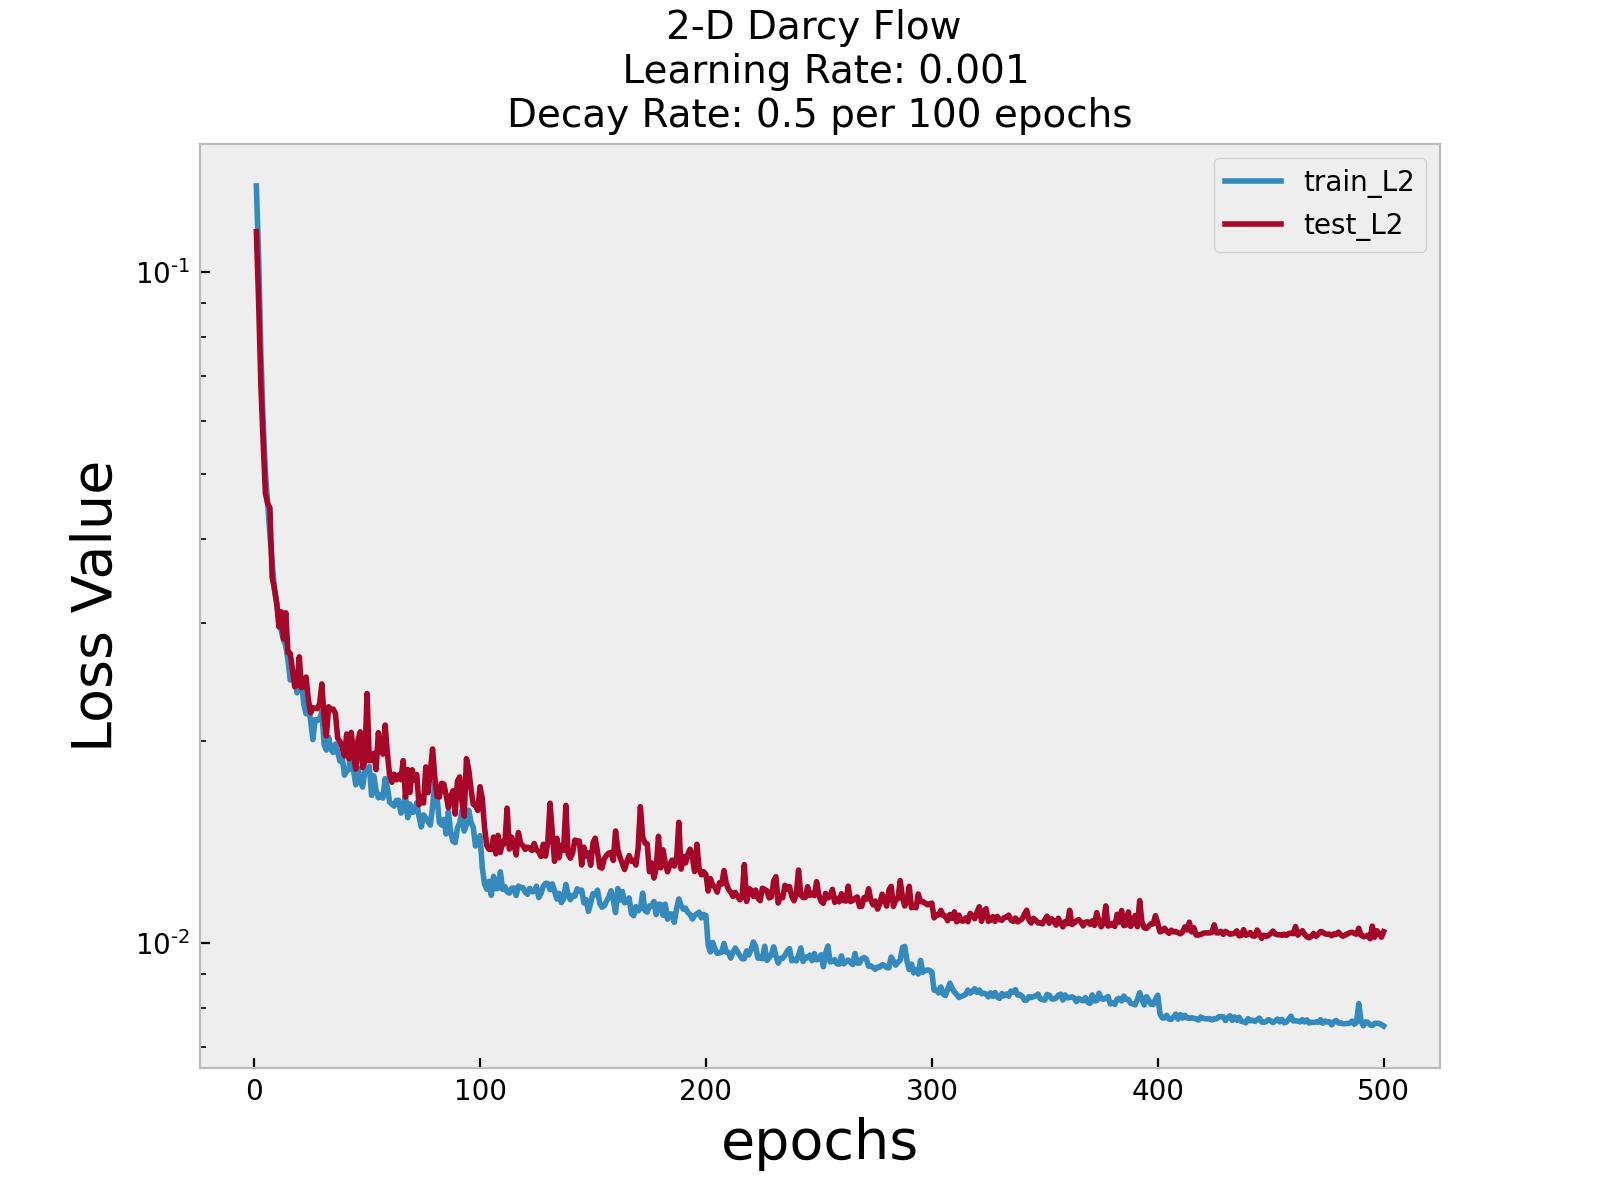

In [18]:
saveLossFig = False
lossfig_path = '../figs/darcy/loss/'
lossfig_name = 'ep' + str(epochs) + \
               '-lr' + "".join(str(learning_rate).split('.')) + \
               '-decay' + "".join(str(gamma).split('.')) + \
               '-trainRes' + str(train_res) + \
               '-testRes' + str(test_res)

figtitle = '2-D Darcy Flow \n Learning Rate: ' + str(learning_rate) + '\n' + \
           'Decay Rate: ' + str(gamma) + ' per ' + str(step_size) + ' epochs'
plot_loss(figtitle = figtitle,
          figpath = lossfig_path, 
          figname = lossfig_name,
          savefig = saveLossFig, 
          train_L2 = train_L2_Loss, 
          test_L2 = test_L2_Loss)
print('minimal relative L2:', min(test_L2_Loss))